<a href="https://colab.research.google.com/github/serifeakbb/radar-elektronik-harp-YZ/blob/main/EH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow scikit-learn scipy pandas numpy matplotlib seaborn -q

import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import signal
from scipy.fft import fft
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# GPU Kontrolü
gpus = tf.config.list_physical_devices('GPU')
print(f"✓ GPU: {len(gpus)} GPU Bulundu")
print(f"✓ TensorFlow: {tf.__version__}")

✓ GPU: 1 GPU Bulundu
✓ TensorFlow: 2.19.0


In [ ]:
class RadarDatasetGenerator:


    def __init__(self, random_state=42):
        np.random.seed(random_state)

        # Gerçek Radar Parametreleri
        self.radar_types = {
            'S-400_Triumf': {
                'freq_range': (400, 450),
                'pri_range': (400, 600),
                'pw_range': (1.5, 3),
                'bw_range': (10, 20),
            },
            'Patriot_MPD': {
                'freq_range': (300, 350),
                'pri_range': (300, 500),
                'pw_range': (2, 4),
                'bw_range': (15, 30),
            },
            'SPADA_2000': {
                'freq_range': (420, 480),
                'pri_range': (250, 400),
                'pw_range': (1, 2),
                'bw_range': (8, 15),
            },
            'Hawk_SAM': {
                'freq_range': (350, 400),
                'pri_range': (350, 550),
                'pw_range': (1.5, 3),
                'bw_range': (12, 25),
            },
            'Anka_EH': {
                'freq_range': (200, 500),
                'pri_range': (200, 800),
                'pw_range': (0.5, 5),
                'bw_range': (5, 50),
            }
        }

    def generate_iq_signal(self, radar_type, n_samples=32768, fs=1e7, snr_db=10):
        """Fiziksel olarak gerçekçi I/Q sinyali oluştur"""
        t = np.arange(n_samples) / fs
        sig = self.radar_types[radar_type]

        fc = np.random.uniform(*sig['freq_range']) * 1e6
        bw = np.random.uniform(*sig['bw_range']) * 1e6

        # Radar Türüne Göre Sinyal Üret
        if radar_type == 'S-400_Triumf':
            signal_t = np.cos(2 * np.pi * fc * t)

        elif radar_type == 'Patriot_MPD':
            barker_11 = np.array([1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1])
            code_reps = int(n_samples / len(barker_11)) + 1
            barker = np.tile(barker_11, code_reps)[:n_samples]
            signal_t = barker * np.cos(2 * np.pi * fc * t)

        elif radar_type == 'SPADA_2000':
            n_code = 32
            phase = np.exp(1j * 2 * np.pi * np.arange(n_code)**2 / n_code)
            code_reps = int(n_samples / len(phase)) + 1
            pattern = np.tile(phase, code_reps)[:n_samples]
            signal_t = np.real(pattern * np.exp(1j * 2 * np.pi * fc * t))

        elif radar_type == 'Hawk_SAM':
            n_code = 64
            frank = np.exp(1j * 2 * np.pi * np.arange(n_code)**2 / n_code)
            code_reps = int(n_samples / len(frank)) + 1
            pattern = np.tile(frank, code_reps)[:n_samples]
            signal_t = np.real(pattern * np.exp(1j * 2 * np.pi * fc * t))

        elif radar_type == 'Anka_EH':
            f_start = fc - bw / 2
            f_end = fc + bw / 2
            signal_t = signal.chirp(t, f_start, t[-1], f_end)

        # AWGN Gürültü Ekle
        power = np.mean(signal_t**2)
        noise_power = power / (10**(snr_db/10))
        noise = np.random.normal(0, np.sqrt(noise_power), n_samples)
        signal_t = signal_t + noise

        # I/Q Bileşenleri
        i = signal_t
        q = signal.hilbert(signal_t).imag

        return np.column_stack([i, q])

    def generate_dataset(self, n_per_class=300, n_samples=32768):
        """Tüm Veri Seti Oluştur"""
        X_data = []
        y_labels = []
        metadata = []

        for radar in self.radar_types.keys():
            print(f"  ✓ {radar}")
            for i in range(n_per_class):
                snr = np.random.uniform(5, 20)
                iq = self.generate_iq_signal(radar, n_samples, snr_db=snr)
                X_data.append(iq)
                y_labels.append(radar)

                sig = self.radar_types[radar]
                metadata.append({
                    'radar': radar,
                    'snr_db': snr,
                    'freq_mhz': np.random.uniform(*sig['freq_range']),
                    'pri_us': np.random.uniform(*sig['pri_range']),
                    'pw_us': np.random.uniform(*sig['pw_range']),
                    'bw_mhz': np.random.uniform(*sig['bw_range'])
                })

        return np.array(X_data), np.array(y_labels), pd.DataFrame(metadata)

print("✓ Veri Seti Oluşturucu Hazır")

✓ Veri Seti Oluşturucu Hazır


In [ ]:
print("📊 VERİ SETİ OLUŞTURULUYOR\n")

generator = RadarDatasetGenerator()
X_data, y_labels, metadata = generator.generate_dataset(n_per_class=300)

print(f"\n✓ {len(X_data)} sinyal oluşturuldu")
print(f"✓ Boyut: {X_data.shape}")
print(f"✓ Radar Türleri: {np.unique(y_labels)}")

📊 VERİ SETİ OLUŞTURULUYOR

  ✓ S-400_Triumf
  ✓ Patriot_MPD
  ✓ SPADA_2000
  ✓ Hawk_SAM
  ✓ Anka_EH

✓ 1500 sinyal oluşturuldu
✓ Boyut: (1500, 32768, 2)
✓ Radar Türleri: ['Anka_EH' 'Hawk_SAM' 'Patriot_MPD' 'S-400_Triumf' 'SPADA_2000']


📊 GÖRSELLEŞTİRME



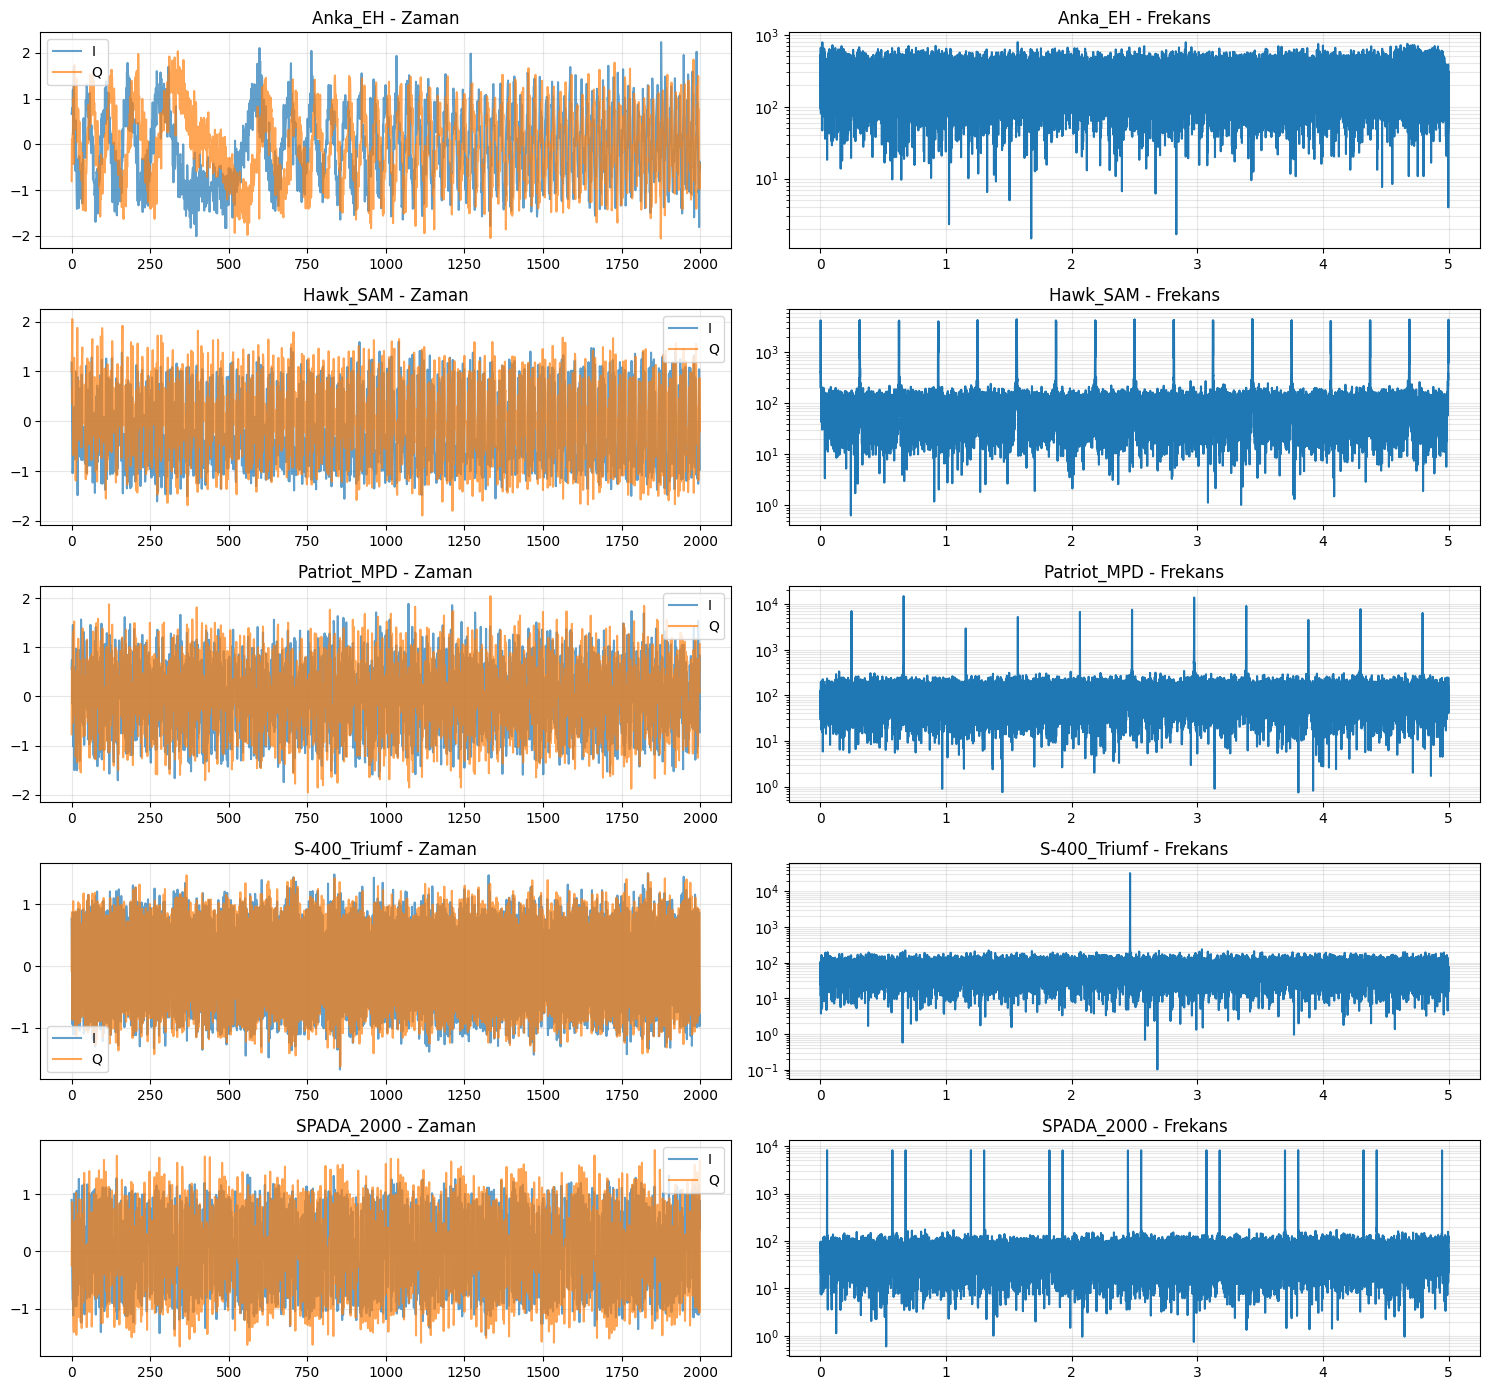

✓ Grafikler kaydedildi



In [ ]:
print("📊 GÖRSELLEŞTİRME\n")

fig, axes = plt.subplots(5, 2, figsize=(15, 14))

for idx, radar in enumerate(np.unique(y_labels)):
    indices = np.where(y_labels == radar)[0]
    sample = X_data[indices[0]]

    i, q = sample[:, 0], sample[:, 1]

    # Zaman Domeni
    axes[idx, 0].plot(i[:2000], label='I', alpha=0.7)
    axes[idx, 0].plot(q[:2000], label='Q', alpha=0.7)
    axes[idx, 0].set_title(f'{radar} - Zaman')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)

    # Frekans Domeni
    iq_c = i + 1j * q
    fft_result = np.abs(fft(iq_c))
    freq = np.fft.fftfreq(len(fft_result), 1/1e7)[:len(fft_result)//2]
    axes[idx, 1].semilogy(freq/1e6, fft_result[:len(fft_result)//2])
    axes[idx, 1].set_title(f'{radar} - Frekans')
    axes[idx, 1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('signals.png', dpi=100, bbox_inches='tight')
plt.show()
print("✓ Grafikler kaydedildi\n")



In [ ]:
print("📋 PREPROCESSING\n")

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Normalize
scaler = StandardScaler()
X_reshaped = X_data.reshape(-1, 2)
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X_data.shape)

# Encode
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_labels)

print(f"  Etiketler:")
for i, name in enumerate(encoder.classes_):
    print(f"    {i}: {name}")

# Split
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_scaled, y_encoded, metadata,
    test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n✓ Train: {len(X_train)}, Test: {len(X_test)}")

📋 PREPROCESSING

  Etiketler:
    0: Anka_EH
    1: Hawk_SAM
    2: Patriot_MPD
    3: S-400_Triumf
    4: SPADA_2000

✓ Train: 1200, Test: 300


In [ ]:
print(" LSTM/CNN HİBRİD MODELİ\n")

from tensorflow.keras import layers, models

def build_lstm_cnn_hybrid(input_shape, n_classes):
    """
    LSTM/CNN Hibrit Model
    Referans: IEEE Xplore 2020 - Zhu et al.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # === CNN BLOKU ===
        layers.Conv1D(32, kernel_size=5, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        # === LSTM BLOKU ===
        layers.Reshape((input_shape[0]//8, 128)),

        layers.LSTM(128, return_sequences=True, dropout=0.2),
        layers.LSTM(64, return_sequences=False, dropout=0.2),

        # === DENSE BLOKU ===
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(n_classes, activation='softmax')
    ])

    return model

input_shape = (X_train.shape[1], X_train.shape[2])
n_classes = len(np.unique(y_encoded))

model = build_lstm_cnn_hybrid(input_shape, n_classes)

print("✓ Model Mimarisi:")
model.summary()

# Derle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("\n✓ Model Derlenmiş")

🤖 LSTM/CNN HİBRİD MODELİ

✓ Model Mimarisi:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 32768, 32)      │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32768, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 16384, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16384, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 16384, 64)      │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16384, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 8192, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8192, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 8192, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8192, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4096, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4096, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 4096, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,149 (914.64 KB)

 Trainable params: 233,701 (912.89 KB)

 Non-trainable params: 448 (1.75 KB)


✓ Model Derlenmiş


In [ ]:
print("\n🚀 EĞİTİM\n")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Eğitim Tamamlandı")


🚀 EĞİTİM

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 425ms/step - accuracy: 0.2450 - loss: 1.5716 - val_accuracy: 0.3042 - val_loss: 1.4594 - learning_rate: 0.0010
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - accuracy: 0.4246 - loss: 1.1588 - val_accuracy: 0.2125 - val_loss: 1.7847 - learning_rate: 0.0010
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 403ms/step - accuracy: 0.6568 - loss: 0.7250 - val_accuracy: 0.2000 - val_loss: 1.6719 - learning_rate: 0.0010
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 410ms/step - accuracy: 0.7653 - loss: 0.4751 - val_accuracy: 0.2667 - val_loss: 1.6121 - learning_rate: 0.0010
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step - accuracy: 0.8047 - loss: 0.3194 - val_accuracy: 0.5417 - val_loss: 1.0898 - learning_rate: 0.0010
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - accuracy: 0.8171 - loss: 0.3206 - val_accuracy: 0.6250 - val_loss: 0.8100 - learning_rate: 0.0010
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 400ms/step - accuracy: 0.7983

📊 DEĞERLENDİRME

✓ Test Accuracy: 80.67%

✓ Detaylı Rapor:
              precision    recall  f1-score   support

     Anka_EH     0.5104    0.8167    0.6282        60
    Hawk_SAM     1.0000    1.0000    1.0000        60
 Patriot_MPD     1.0000    1.0000    1.0000        60
S-400_Triumf     0.5417    0.2167    0.3095        60
  SPADA_2000     1.0000    1.0000    1.0000        60

    accuracy                         0.8067       300
   macro avg     0.8104    0.8067    0.7875       300
weighted avg     0.8104    0.8067    0.7875       300



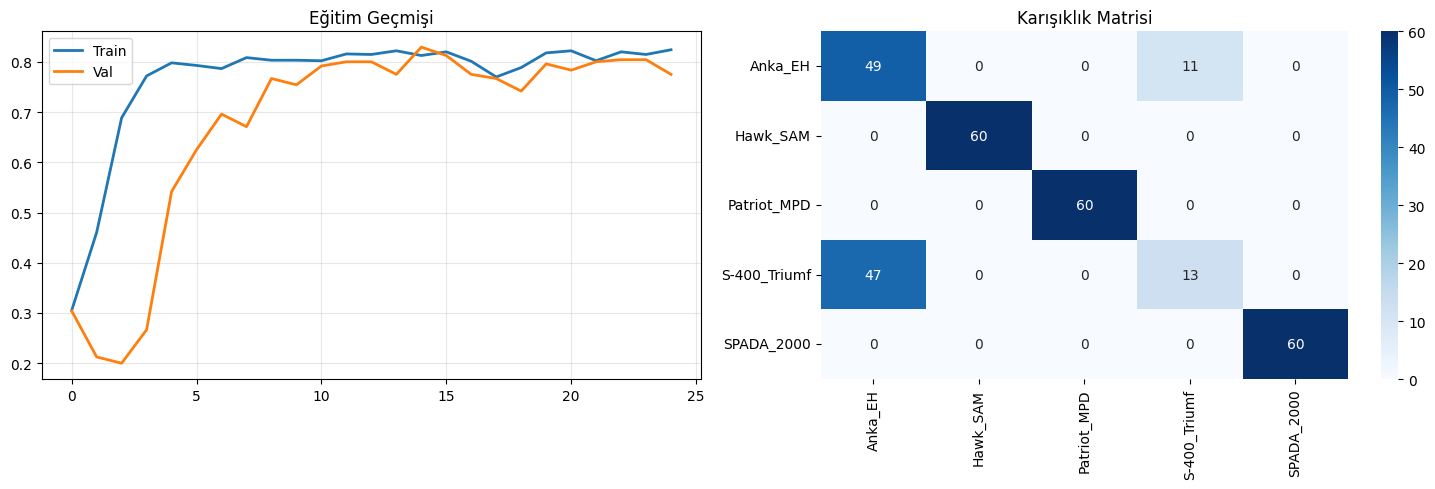

In [ ]:
print("📊 DEĞERLENDİRME\n")

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
print(f"✓ Test Accuracy: {acc*100:.2f}%")

print(f"\n✓ Detaylı Rapor:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_, digits=4))

# Görselleştir
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val', linewidth=2)
axes[0].set_title('Eğitim Geçmişi')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_,
            ax=axes[1])
axes[1].set_title('Karışıklık Matrisi')

plt.tight_layout()
plt.savefig('evaluation.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
print("📝 YAYIN LİSTESİ\n")

y_pred_proba = model.predict(X_test, verbose=0)
y_pred_encoded = np.argmax(y_pred_proba, axis=1)
confidence = np.max(y_pred_proba, axis=1)

detected = encoder.inverse_transform(y_pred_encoded)
ground_truth = encoder.inverse_transform(y_test)

# Tehdit Seviyesi
threats = []
for conf in confidence:
    if conf > 0.90:
        threats.append('KRITIK')
    elif conf > 0.75:
        threats.append('YÜKSEK')
    elif conf > 0.60:
        threats.append('ORTA')
    else:
        threats.append('DÜŞÜK')

# Yayın Listesi
emission_list = pd.DataFrame({
    'Signal_Index': np.arange(len(X_test)),
    'Detected_Radar': detected,
    'Ground_Truth': ground_truth,
    'Correct': (detected == ground_truth).astype(int),
    'Confidence': np.round(confidence, 4),
    'Threat_Level': threats,
    'Frequency_MHz': meta_test['freq_mhz'].values,
    'PRI_us': meta_test['pri_us'].values,
    'Pulse_Width_us': meta_test['pw_us'].values,
    'Bandwidth_MHz': meta_test['bw_mhz'].values
})

emission_list.to_csv('emission_list.csv', index=False)

print("✓ İlk 20 Satır:")
print(emission_list.head(20))

print(f"\n✓ İSTATİSTİKLER:")
print(f"  - Doğru Sınıflandırma: {emission_list['Correct'].sum()}/{len(emission_list)}")
print(f"  - KRİTİK: {(emission_list['Threat_Level']=='KRITIK').sum()}")
print(f"  - YÜKSEK: {(emission_list['Threat_Level']=='YÜKSEK').sum()}")
print(f"  - ORTA: {(emission_list['Threat_Level']=='ORTA').sum()}")
print(f"  - DÜŞÜK: {(emission_list['Threat_Level']=='DÜŞÜK').sum()}")


📝 YAYIN LİSTESİ

✓ İlk 20 Satır:
    Signal_Index Detected_Radar  Ground_Truth  Correct  Confidence  \
0              0       Hawk_SAM      Hawk_SAM        1      1.0000   
1              1       Hawk_SAM      Hawk_SAM        1      1.0000   
2              2        Anka_EH  S-400_Triumf        0      0.5352   
3              3     SPADA_2000    SPADA_2000        1      0.9993   
4              4     SPADA_2000    SPADA_2000        1      0.9993   
5              5   S-400_Triumf  S-400_Triumf        1      0.5013   
6              6     SPADA_2000    SPADA_2000        1      0.9992   
7              7        Anka_EH       Anka_EH        1      0.5259   
8              8       Hawk_SAM      Hawk_SAM        1      1.0000   
9              9     SPADA_2000    SPADA_2000        1      0.9993   
10            10    Patriot_MPD   Patriot_MPD        1      0.9995   
11            11       Hawk_SAM      Hawk_SAM        1      1.0000   
12            12       Hawk_SAM      Hawk_SAM        1   